In [129]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [130]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [131]:
NUM_CLASSES = 4

# 学習データ読み込み

In [132]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [133]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [135]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [136]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 42)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                860       
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [137]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [138]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [139]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/31 [..............................] - ETA: 9s - loss: 1.3604 - accuracy: 0.2812
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
31/31 [==============================] - 0s 5ms/step - loss: 1.3794 - accuracy: 0.3171 - val_loss: 1.2997 - val_accuracy: 0.3479
Epoch 2/1000
 1/31 [..............................] - ETA: 0s - loss: 1.3261 - accuracy: 0.3750
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
31/31 [==============================] - 0s 2ms/step - loss: 1.2874 - accuracy: 0.3660 - val_loss: 1.2251 - val_accuracy: 0.4286
Epoch 3/1000
 1/31 [..............................] - ETA: 0s - loss: 1.2771 - accuracy: 0.4141
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
31/31 [==============================] - 0s 2ms/step - loss: 1.2449 - accuracy: 0.3957 - val_loss: 1.1662 - val_accuracy: 0.4593
Epoch 4/1000
 1/31 [..............................] - ETA: 0s - loss: 1.2169 - accuracy: 0.4375
E

In [140]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 936us/step - loss: 0.2359 - accuracy: 0.9217


In [141]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [142]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 29ms/step
[0.3171868  0.01609338 0.00447605 0.6622438 ]
3


# 混同行列

41/41 [==============================] - 0s 593us/step


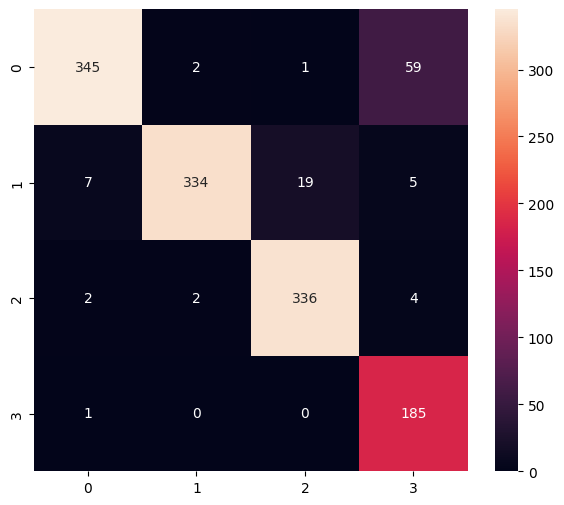

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       407
           1       0.99      0.92      0.95       365
           2       0.94      0.98      0.96       344
           3       0.73      0.99      0.84       186

    accuracy                           0.92      1302
   macro avg       0.91      0.93      0.91      1302
weighted avg       0.93      0.92      0.92      1302



In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [144]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [145]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpr05vnp4w/assets


INFO:tensorflow:Assets written to: /tmp/tmpr05vnp4w/assets
2023-04-19 18:24:02.605126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-19 18:24:02.605155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-19 18:24:02.605363: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr05vnp4w
2023-04-19 18:24:02.606301: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-19 18:24:02.606318: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr05vnp4w
2023-04-19 18:24:02.609397: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-19 18:24:02.633367: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr05vnp4w
2023-04-19 18:24:02.638798: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6608

# 推論テスト

In [146]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [147]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [148]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [149]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 39 µs, sys: 4 µs, total: 43 µs
Wall time: 65.3 µs


In [150]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.3171868  0.01609338 0.00447605 0.66224384]
3
